## 트랜스 포머를 이용한 음악생성

- 파라메터

In [1]:
import sys
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/01_transformer/transformer_utils.py
    # output 디렉토리를 만듭니다.
    !mkdir bach-cello
    !mkdir parsed_data
    !mkdir models
    !mkdir output
    # 악보 이미지 생성을 위해
    !apt-get install lilypond > /dev/null

--2024-04-05 11:30:34--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/01_transformer/transformer_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6876 (6.7K) [text/plain]
Saving to: ‘transformer_utils.py’

transformer_utils.p 100%[===================>]   6.71K  --.-KB/s    in 0s      

2024-04-05 11:30:35 (58.2 MB/s) - ‘transformer_utils.py’ saved [6876/6876]

Extracting templates from packages: 100%


In [2]:
# 필요한 라이브러리
import os
import glob
import numpy as np
import time
import sys
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils  import(
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding
)

In [3]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = './parsed_data'
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# 최적화
EPOCHS = 20
BATCH_SIZE = 256
GENERATE_LEN = 50

In [4]:
if 'google.colab' in sys.modules:
    %cd ./bach-cello/
    !curl -O http://www.jsbach.net/midi/cs1-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-5men.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-5men.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-5bou.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-5bou.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-5gav.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-5gav.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-6gig.mid -s
    %cd ..

/content/bach-cello
/content


In [5]:
# 데이터 로드
file_list = glob.glob("./bach-cello/*.mid")
len(file_list)

36

In [6]:
parser = music21.converter

In [7]:
example_score = music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()

In [8]:
from IPython.display import Image, Audio

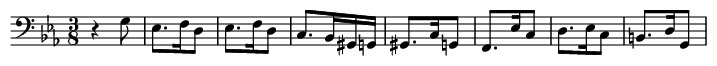

In [9]:
display(Image(str(example_score.write('lily.png'))))

In [10]:
example_score.show('text')

{0.0} <music21.metadata.Metadata object at 0x78356d97e0e0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of E- major>
    {0.0} <music21.meter.TimeSignature 3/8>
    {0.0} <music21.note.Rest quarter>
    {1.0} <music21.tempo.MetronomeMark Quarter=100>
    {1.0} <music21.chord.Chord G3>
{1.5} <music21.stream.Measure 2 offset=1.5>
    {0.0} <music21.chord.Chord E-3>
    {0.75} <music21.chord.Chord F3>
    {1.0} <music21.chord.Chord D3>
{3.0} <music21.stream.Measure 3 offset=3.0>
    {0.0} <music21.chord.Chord E-3>
    {0.75} <music21.chord.Chord F3>
    {1.0} <music21.chord.Chord D3>
{4.5} <music21.stream.Measure 4 offset=4.5>
    {0.0} <music21.chord.Chord C3>
    {0.75} <music21.chord.Chord B-2>
    {1.0} <music21.chord.Chord G#2>
    {1.25} <music21.cho

In [11]:
if PARSE_MIDI_FILES:
  notes,durations = parse_midi_files(
      file_list, parser, SEQ_LEN+1, PARSED_DATA_PATH
  )
else:
  notes,durations = load_parsed_files()

1 ./bach-cello/cs6-5gav.mid 파싱


<ipython-input-11-dc7fe351bfbe>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes,durations = parse_midi_files(


806개 음표 파싱
2 ./bach-cello/cs5-6gig.mid 파싱
1255개 음표 파싱
3 ./bach-cello/cs5-2all.mid 파싱
1947개 음표 파싱
4 ./bach-cello/cs4-6gig.mid 파싱
2918개 음표 파싱
5 ./bach-cello/cs4-2all.mid 파싱
3973개 음표 파싱
6 ./bach-cello/cs2-1pre.mid 파싱
4611개 음표 파싱
7 ./bach-cello/cs6-6gig.mid 파싱
5783개 음표 파싱
8 ./bach-cello/cs2-4sar.mid 파싱
6120개 음표 파싱
9 ./bach-cello/cs4-4sar.mid 파싱
6440개 음표 파싱
10 ./bach-cello/cs3-5bou.mid 파싱
7321개 음표 파싱
11 ./bach-cello/cs3-4sar.mid 파싱
7662개 음표 파싱
12 ./bach-cello/cs6-2all.mid 파싱
8347개 음표 파싱
13 ./bach-cello/cs5-1pre.mid 파싱
9656개 음표 파싱
14 ./bach-cello/cs6-4sar.mid 파싱
9991개 음표 파싱
15 ./bach-cello/cs2-5men.mid 파싱
10518개 음표 파싱
16 ./bach-cello/cs5-3cou.mid 파싱
10948개 음표 파싱
17 ./bach-cello/cs1-3cou.mid 파싱
11768개 음표 파싱
18 ./bach-cello/cs1-1pre.mid 파싱
12426개 음표 파싱
19 ./bach-cello/cs1-4sar.mid 파싱
12689개 음표 파싱
20 ./bach-cello/cs4-5bou.mid 파싱
14013개 음표 파싱
21 ./bach-cello/cs1-2all.mid 파싱
14934개 음표 파싱
22 ./bach-cello/cs3-2all.mid 파싱
15671개 음표 파싱
23 ./bach-cello/cs2-3cou.mid 파싱
16412개 음표 파싱
24 ./bach-cello/cs6-

In [12]:
example_notes = notes[658]
example_durations = durations[658]
example_notes,example_durations

('E4 D4 E4 F#4 G4 D4 C#4 B3 A3 D4 D4 D4 C#4 D4 C#4 B3 E4 C#4 A4 A4 A4 B4 A4 G4 F#4 B4 A4 G4 F#4 E4 A3 G4 F#4 E4 G3 E-4 E4 G4 A3 F#4 B3 E-4 E3 B3 E4 F#4 G4 G4 C#3 E3 A3',
 '0.5 0.5 0.5 0.5 1.0 0.5 0.5 0.5 0.5 1.0 1.0 1.0 0.5 0.5 0.5 0.5 1.0 2.0 1.0 1.0 1.0 0.5 0.5 0.5 0.5 1.0 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.0 1.0 0.5 0.5 0.5')

데이터 토큰화

In [13]:
def create_dataset(elements):
  ds = (
      tf.data.Dataset.from_tensor_slices(elements)
      .batch(BATCH_SIZE,drop_remainder=True)
      .shuffle(1000)
  )
  vectorize_layer = layers.TextVectorization(
      standardize=None, output_mode = 'int'
  )
  vectorize_layer.adapt(ds)
  vocab = vectorize_layer.get_vocabulary()
  return ds, vectorize_layer, vocab

notes_seq_ds, notes_vectorize_layer, notes_vocab =  create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(durations)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))


In [14]:
# 동일한 음표과 지속시간을 int로 변환해서 표시
example_tokenised_notes =  notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print(f"{'note token':<10} {'duration token'}")
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
  ):
  print(f"{note_int:>5} {duration_int:>10}")


note token duration token
   15          3
    7          3
   15          3
   21          3
   22          4
    7          3
   17          3
    9          3
    3          3
    7          4
    7          4


In [15]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# token:note 매핑 예시를 출력합니다.
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


훈련 세트 생성

In [16]:
# 시퀀스와 하나의 음표를 이동한 동일한 시퀀스로 훈련 세트를 만듦
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [17]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[26, 21, 21, ..., 23, 23, 47],
       [21, 21, 36, ..., 23, 47, 23],
       [21, 36, 23, ..., 47, 23, 15],
       ...,
       [ 6,  6, 11, ...,  7,  6, 11],
       [ 6, 11,  6, ...,  6, 11,  3],
       [11,  6,  3, ..., 11,  3,  2]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 6, ..., 2, 2, 2],
       [2, 6, 2, ..., 2, 2, 2],
       [6, 2, 3, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 3, 2],
       [2, 2, 2, ..., 3, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[21, 21, 36, ..., 23, 47, 23],
       [21, 36, 23, ..., 47, 23, 15],
       [36, 23, 28, ..., 23, 15, 15],
       ...,
       [ 6, 11,  6, ...,  6, 11,  3],
       [11,  6,  3, ..., 11,  3,  2],
       [ 6,  3, 11, ...,  3,  2,  7]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2,  6,  2, ...,  2,  2,  2],
       [ 6,  2,  3, ...,  2,  2,  2],
       [ 2,  3, 10, ...,  2,  2

- 코잘 어텐션 마스크 함수

In [18]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

- 트랜스포커 블록 층

In [19]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads    # 어텐션 해드 개수
        self.key_dim = key_dim        # 어텐션 키의 차원
        self.embed_dim = embed_dim    # 임베딩 차원
        self.ff_dim = ff_dim          # 피드포워드 신경망의 차원
        self.dropout_rate = dropout_rate      # 드랍아웃 비율
        # 신경망 초기화
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        # 코잘 어텐션 마스크 생성
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        # 멀티 해드 어텐션 수행
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        # 레지듀얼 커넥션과 정규화
        out1 = self.ln_1(inputs + attention_output)
        # 피드포워드 신경망 수행
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        # 두번째 레지듀얼 커넥션과 정규화
        return (self.ln_2(out1 + ffn_output), attention_scores)

    # 설정함수, 모델의 설정을 반환
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

토큰과 위치 임베딩

In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

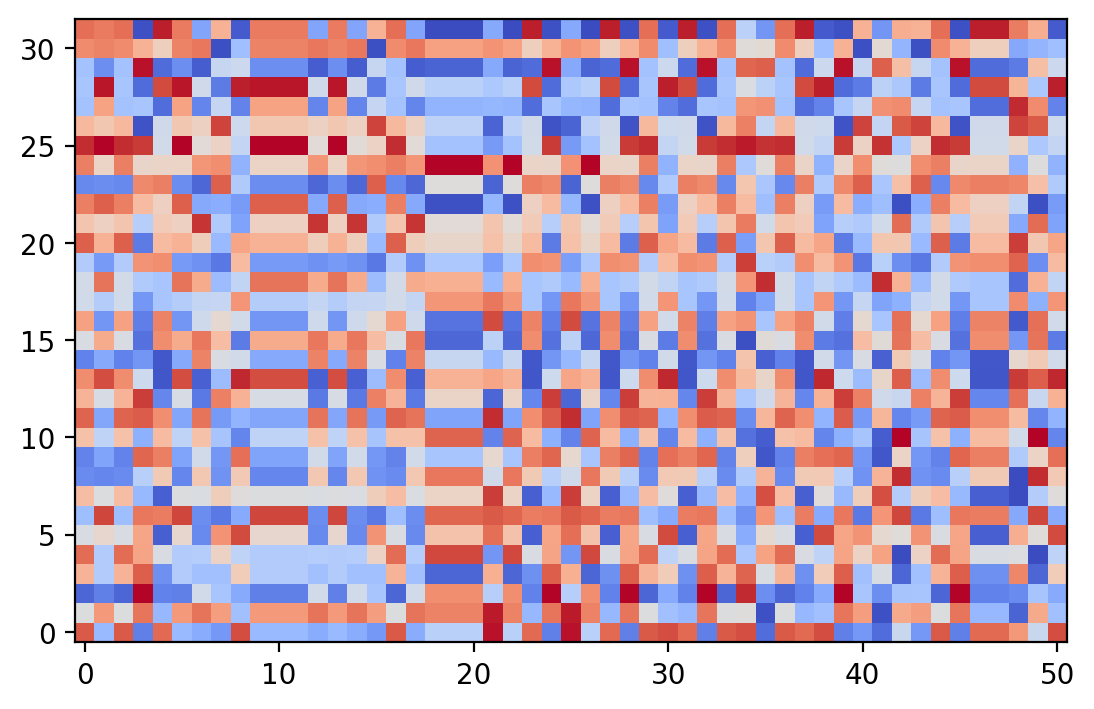

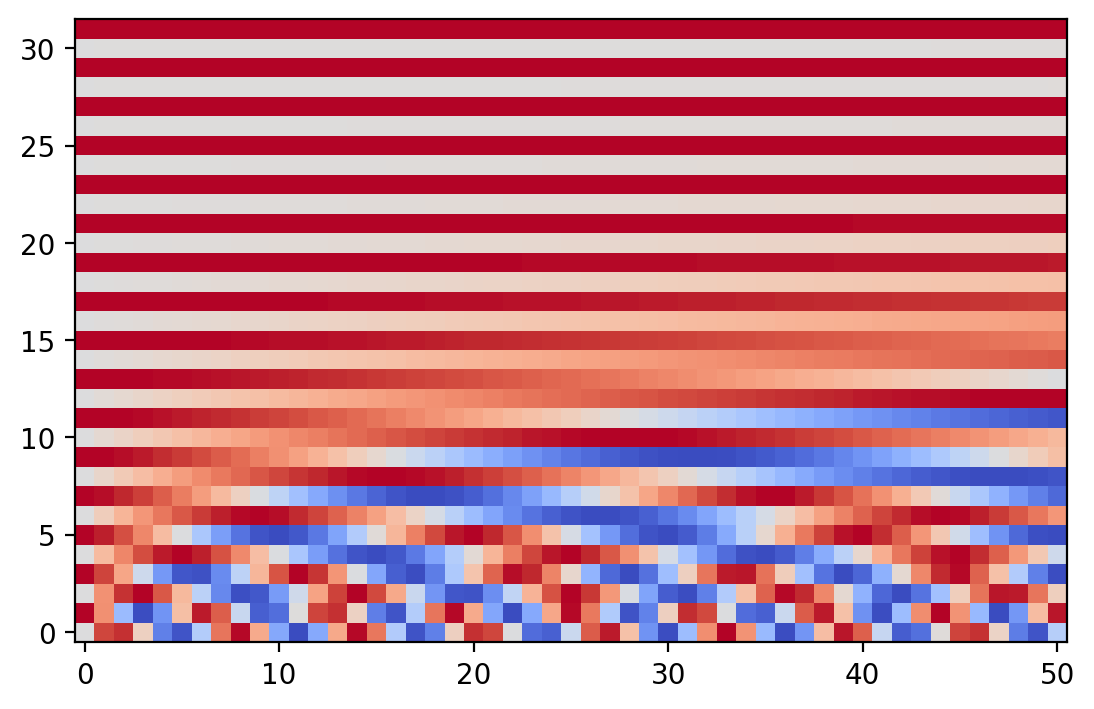

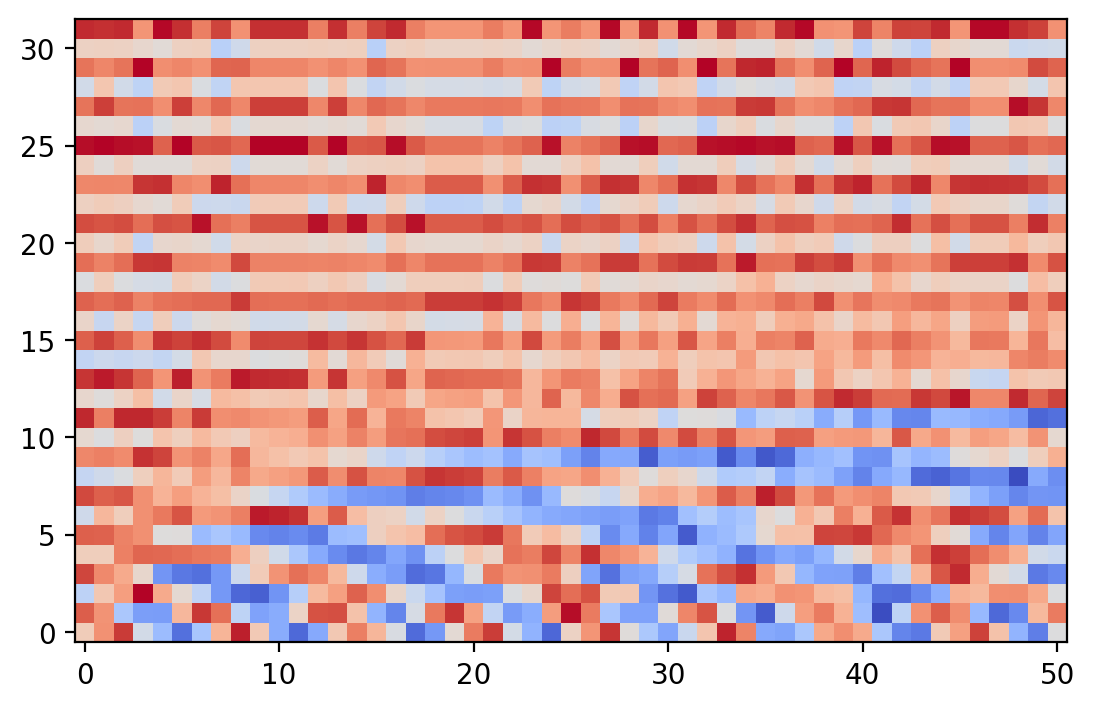

In [21]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

트랜스포머 모델 구축

In [22]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention")(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs")(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs")(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 128)            7552      ['input_1[0][0]']             
 ng_1 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                              

In [24]:
if LOAD_MODEL:
  model.load_weights("./checkpoint/checkpoint.ckpt")

트랜스포머 훈련하기

In [25]:
# MusicGenerator 체크포인트 만들기
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])

        display(Image(str(midi_stream.write('lily.png'))))
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "./output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

- 모델 저장 체크포인트 만들기

In [26]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./checkpoint/checkpoint.ckpt',
    save_weights_only=True,
    save_freq='epoch',
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')
# 시작프롬프트 토큰화
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 4.7316 - note_outputs_loss: 3.4748 - duration_outputs_loss: 1.2568[['START', 'E3', 'C4', 'G3', 'D4', 'A3', 'A3', 'B3', 'G3', 'D3', 'E3', 'D3', 'D3', 'D3', 'D3', 'G3', 'D4', 'B3', 'D3', 'D4', 'D3', 'E3', 'G3', 'A3', 'C4', 'D3', 'D4', 'F3', 'D3', 'E3', 'F3', 'D4', 'E3', 'D3', 'A3', 'D4', 'E3', 'E3', 'G3', 'B3', 'G3', 'D4', 'A3', 'E3', 'G3', 'B-3', 'A3', 'G3', 'D3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


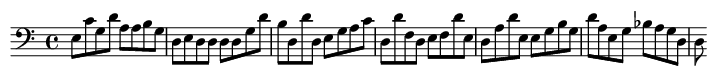

107/107 [==============================] - 24s 161ms/step - loss: 4.7316 - note_outputs_loss: 3.4748 - duration_outputs_loss: 1.2568
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 4.0351 - note_outputs_loss: 3.2901 - duration_outputs_loss: 0.7450[['START', 'A3', 'A3', 'G3', 'A3', 'A3', 'B3', 'A3', 'G3', 'A3', 'A3', 'A3', 'F#3', 'G3', 'G3', 'F3', 'G3', 'G3', 'G3', 'G3', 'F#3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'F#3', 'G3', 'G3', 'G3', 'G3', 'F3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


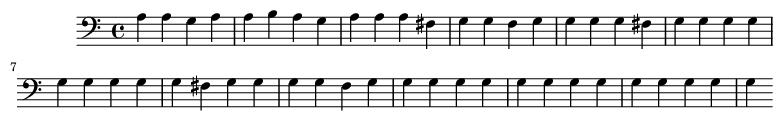

107/107 [==============================] - 15s 139ms/step - loss: 4.0351 - note_outputs_loss: 3.2901 - duration_outputs_loss: 0.7450
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 3.6649 - note_outputs_loss: 2.9523 - duration_outputs_loss: 0.7126[['START', 'C#4', 'D4', 'B3', 'D4', 'A4', 'D3', 'C#4', 'B3', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'A3', 'C4', 'B-3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B-3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'G3', 'A3', 'C4', 'B3', 'C4', 'A3', 'B3', 'A3', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


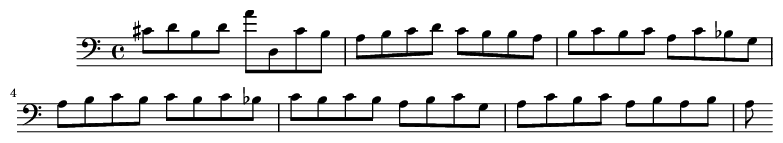

107/107 [==============================] - 20s 185ms/step - loss: 3.6649 - note_outputs_loss: 2.9523 - duration_outputs_loss: 0.7126
Epoch 4/20
107/107 [==============================] - ETA: 0s - loss: 3.4154 - note_outputs_loss: 2.7518 - duration_outputs_loss: 0.6636[['START', 'G4', 'F#4', 'G4', 'A4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'G4', 'A4', 'G4', 'A4', 'G4', 'G4', 'F#4', 'F#4', 'F#4', 'A4', 'A4', 'A4', 'A4', 'G4', 'F#4', 'F#4', 'B4', 'A4', 'F#4', 'F#4', 'G4', 'B4', 'A4', 'F#4', 'G4', 'A4', 'G4', 'G4', 'G4', 'A4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'A4'], ['0.0', '1/12', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


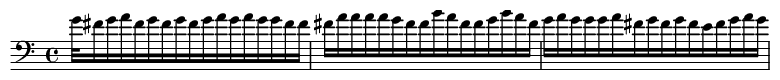

107/107 [==============================] - 15s 138ms/step - loss: 3.4154 - note_outputs_loss: 2.7518 - duration_outputs_loss: 0.6636
Epoch 5/20
107/107 [==============================] - ETA: 0s - loss: 3.2555 - note_outputs_loss: 2.6289 - duration_outputs_loss: 0.6265[['START', 'B4', 'F#4', 'G4', 'F#4', 'B4', 'A4', 'G4', 'B4', 'G#4', 'A4', 'A4', 'B4', 'G4', 'E4', 'F#4', 'E4', 'G4', 'D4', 'E4', 'E4', 'E4', 'E4', 'G4', 'E4', 'E4', 'G4', 'F#4', 'E4', 'D4', 'E4', 'E4', 'G4', 'G4', 'F#4', 'F#4', 'G4', 'F#4', 'F#4', 'F#4', 'G#4', 'A4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'G4', 'F#4'], ['0.0', '1/12', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


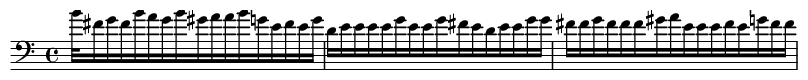

107/107 [==============================] - 16s 151ms/step - loss: 3.2555 - note_outputs_loss: 2.6289 - duration_outputs_loss: 0.6265
Epoch 6/20
107/107 [==============================] - ETA: 0s - loss: 3.1653 - note_outputs_loss: 2.5573 - duration_outputs_loss: 0.6079[['START', 'E-:major', '4/4TS', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'B4', 'A4', 'A4', 'B4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


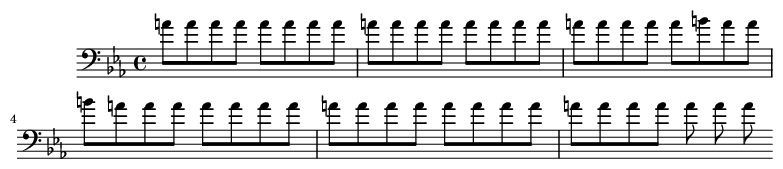

107/107 [==============================] - 15s 137ms/step - loss: 3.1653 - note_outputs_loss: 2.5573 - duration_outputs_loss: 0.6079
Epoch 7/20
107/107 [==============================] - ETA: 0s - loss: 3.1426 - note_outputs_loss: 2.5295 - duration_outputs_loss: 0.6131[['START', 'E-:major', '3/4TS', 'G2', 'G2', 'F2', '3/4TS', 'G2', 'B2', 'C3', 'G2', 'G2', 'G2', 'F2', 'G2', 'G2', 'F2', 'G2', 'G2', 'G2', 'F2', 'E2', 'B2', 'C3', 'G2', 'D3', 'B-2', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'E-3', 'D3', 'E-3', 'C4', 'B-3'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


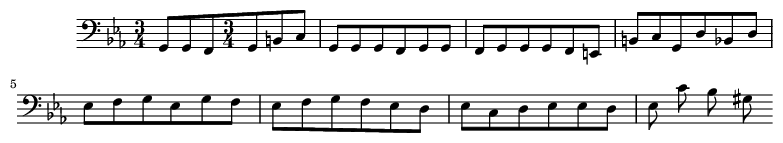

107/107 [==============================] - 15s 138ms/step - loss: 3.1426 - note_outputs_loss: 2.5295 - duration_outputs_loss: 0.6131
Epoch 8/20
107/107 [==============================] - ETA: 0s - loss: 3.0854 - note_outputs_loss: 2.4868 - duration_outputs_loss: 0.5986[['START', '4/4TS', 'E-2', 'rest', 'D5', 'rest', 'A4', 'A4', 'E4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'D4', 'E4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


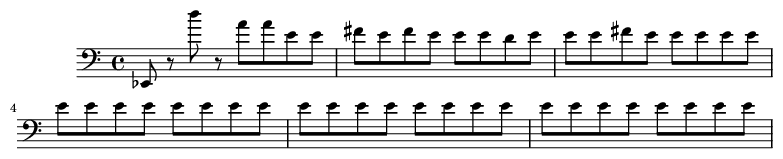

107/107 [==============================] - 14s 130ms/step - loss: 3.0854 - note_outputs_loss: 2.4868 - duration_outputs_loss: 0.5986
Epoch 9/20
107/107 [==============================] - ETA: 0s - loss: 3.0350 - note_outputs_loss: 2.4429 - duration_outputs_loss: 0.5920[['START', 'E-:major', '4/4TS', 'rest'], ['0.0', '0.0', '0.0', '3.75']]


107/107 [==============================] - 9s 79ms/step - loss: 3.0350 - note_outputs_loss: 2.4429 - duration_outputs_loss: 0.5920
Epoch 10/20
107/107 [==============================] - ETA: 0s - loss: 2.9871 - note_outputs_loss: 2.4184 - duration_outputs_loss: 0.5687[['START', 'E-:major', 'E-:major', '3/4TS', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G#2', 'B-3', 'A3', 'G3', 'B-3', 'B-3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]

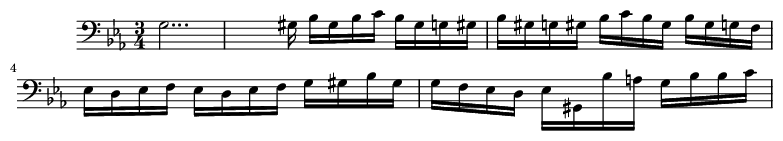

107/107 [==============================] - 15s 143ms/step - loss: 2.9871 - note_outputs_loss: 2.4184 - duration_outputs_loss: 0.5687
Epoch 11/20
107/107 [==============================] - ETA: 0s - loss: 2.9555 - note_outputs_loss: 2.3875 - duration_outputs_loss: 0.5680[['START', '3/4TS', 'rest', 'G4', 'G4', 'G4', 'E4', 'F#4', 'G4', 'G4', 'E4', 'E4', 'E4', 'E4', 'E4', 'G4', 'G4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'C#4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'G4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


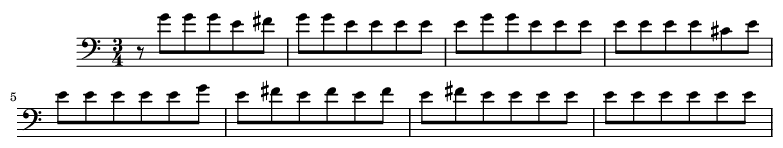

107/107 [==============================] - 15s 136ms/step - loss: 2.9555 - note_outputs_loss: 2.3875 - duration_outputs_loss: 0.5680
Epoch 12/20
107/107 [==============================] - ETA: 0s - loss: 2.9405 - note_outputs_loss: 2.3748 - duration_outputs_loss: 0.5658[['START', 'G:major', '3/4TS', 'G3', 'G#3', 'G3', 'G#3', 'G#3', 'G#3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'G2', 'G2', 'A2', 'G2', 'E3', 'C4', 'E3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'A3', 'C4', 'B3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3'], ['0.0', '0.5', '0.0', '3.75', '0.25', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


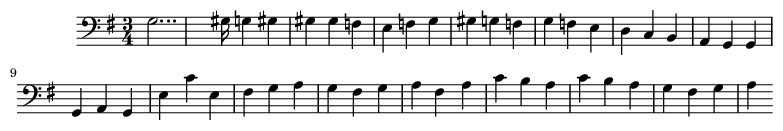

107/107 [==============================] - 14s 131ms/step - loss: 2.9405 - note_outputs_loss: 2.3748 - duration_outputs_loss: 0.5658
Epoch 13/20
107/107 [==============================] - ETA: 0s - loss: 2.9132 - note_outputs_loss: 2.3535 - duration_outputs_loss: 0.5597[['START', 'E-:major', '3/4TS', 'D3', 'C3', 'D3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'E-3', 'F3', 'G3', 'F3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


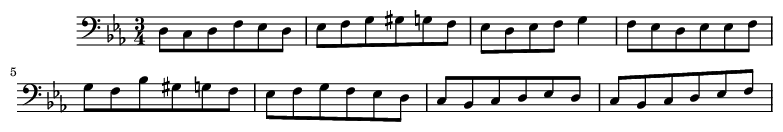

107/107 [==============================] - 15s 136ms/step - loss: 2.9132 - note_outputs_loss: 2.3535 - duration_outputs_loss: 0.5597
Epoch 14/20
107/107 [==============================] - ETA: 0s - loss: 2.8895 - note_outputs_loss: 2.3259 - duration_outputs_loss: 0.5636[['START', '3/4TS', 'rest', 'D4', 'rest', 'G2', 'G2', 'E-2', 'G2', 'rest'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


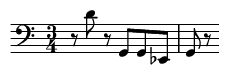

107/107 [==============================] - 10s 90ms/step - loss: 2.8895 - note_outputs_loss: 2.3259 - duration_outputs_loss: 0.5636
Epoch 15/20
107/107 [==============================] - ETA: 0s - loss: 2.8720 - note_outputs_loss: 2.3141 - duration_outputs_loss: 0.5579[['START', '3/4TS', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'E-3', 'D3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


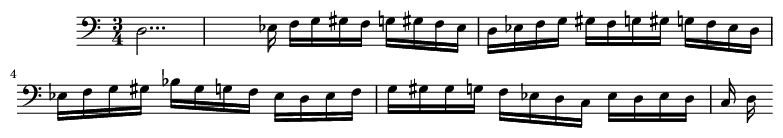

107/107 [==============================] - 15s 138ms/step - loss: 2.8720 - note_outputs_loss: 2.3141 - duration_outputs_loss: 0.5579
Epoch 16/20
107/107 [==============================] - ETA: 0s - loss: 2.8633 - note_outputs_loss: 2.2972 - duration_outputs_loss: 0.5661[['START', '4/4TS', 'rest'], ['0.0', '2.5', '0.5']]


107/107 [==============================] - 9s 85ms/step - loss: 2.8633 - note_outputs_loss: 2.2972 - duration_outputs_loss: 0.5661
Epoch 17/20
107/107 [==============================] - ETA: 0s - loss: 2.8295 - note_outputs_loss: 2.2726 - duration_outputs_loss: 0.5569

[['START', '4/4TS', '4/4TS', 'D5', 'C#5', 'D5', 'A4', 'B4', 'A4', 'A4', 'B4', 'A4', 'B4', 'A4', 'A4', 'B4', 'A4', 'A4', 'A4', 'A4', 'F#4', 'E4', 'F#4', 'E4', 'C#4', 'D4', 'A3', 'B3', 'C#4', 'D4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'E4', 'A4', 'G4', 'F#4', 'E4', 'E4', 'E4', 'F#4', 'F#4', 'E4', 'A4', 'A4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


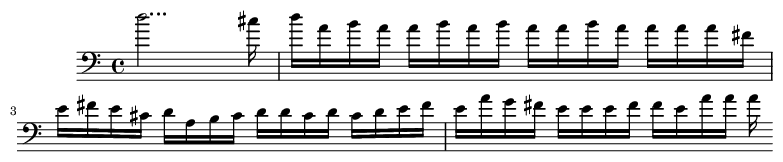

107/107 [==============================] - 15s 145ms/step - loss: 2.8295 - note_outputs_loss: 2.2726 - duration_outputs_loss: 0.5569
Epoch 18/20
107/107 [==============================] - ETA: 0s - loss: 2.8135 - note_outputs_loss: 2.2608 - duration_outputs_loss: 0.5526[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


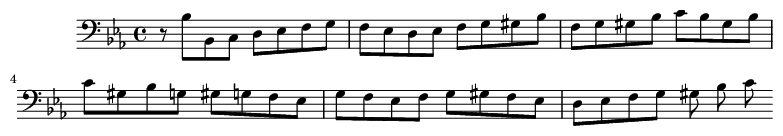

107/107 [==============================] - 15s 139ms/step - loss: 2.8135 - note_outputs_loss: 2.2608 - duration_outputs_loss: 0.5526
Epoch 19/20
107/107 [==============================] - ETA: 0s - loss: 2.8115 - note_outputs_loss: 2.2447 - duration_outputs_loss: 0.5667[['START', '4/4TS', 'rest', 'D4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'F3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'D3', 'F3', 'E3', 'D3', 'C3', 'C2', 'C4', 'D4', 'C4', 'D4', 'B3', 'C4', 'B3', 'C4', 'D4', 'B3', 'D4', 'A3', 'B3', 'G3', 'A3', 'B3', 'C4'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


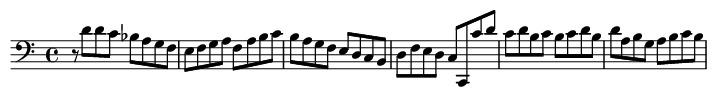

107/107 [==============================] - 14s 133ms/step - loss: 2.8115 - note_outputs_loss: 2.2447 - duration_outputs_loss: 0.5667
Epoch 20/20
107/107 [==============================] - ETA: 0s - loss: 2.7927 - note_outputs_loss: 2.2344 - duration_outputs_loss: 0.5583[['START', '4/4TS', 'rest'], ['0.0', '0.0', '3.75']]


107/107 [==============================] - 8s 77ms/step - loss: 2.7927 - note_outputs_loss: 2.2344 - duration_outputs_loss: 0.5583


In [27]:
model.fit(
    ds,epochs=EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator
    ]
)

In [28]:
model.save('/content/drive/MyDrive/music_transformer.pth')

- 트랜스포머를 사용하여 음악생성

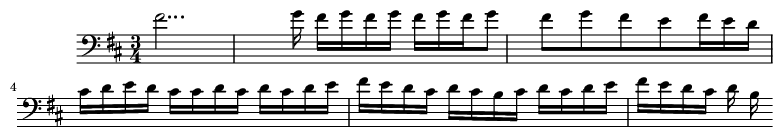

In [29]:
info = music_generator.generate(
    ['START'],['0.0'],max_tokens=50,temperature=0.5
)
midi_stream = info[-1]['midi'].chordify()
display(Image(str(midi_stream.write('lily.png'))))

- MIDI파일로 음악 저장

 - 바흐 코랄 스타일로 음악을 생성

In [31]:
import sys

# 코랩의 경우 깃허브 저장소로부터 musegan_utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
    # output 디렉토리를 만듭니다.
    !mkdir parsed_data
    !mkdir output
    !mkdir bach-chorales
    # 악보 이미지 생성을 위해
    !apt-get install lilypond > /dev/null

--2024-04-05 11:42:33--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1833 (1.8K) [text/plain]
Saving to: ‘musegan_utils.py’

musegan_utils.py    100%[===================>]   1.79K  --.-KB/s    in 0s      

2024-04-05 11:42:33 (35.7 MB/s) - ‘musegan_utils.py’ saved [1833/1833]

mkdir: cannot create directory ‘parsed_data’: File exists
mkdir: cannot create directory ‘output’: File exists


In [32]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
    initializers,
    metrics,
)

from musegan_utils import notes_to_midi, draw_score

- 파라메터셋팅

In [33]:
BATCH_SIZE = 64

N_BARS = 2
N_STEPS_PER_BAR = 16
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32


CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 1000
LOAD_MODEL = False

In [34]:
if 'google.colab' in sys.modules:
    !curl -LO https://github.com/czhuang/JSB-Chorales-dataset/raw/master/Jsb16thSeparated.npz -s
    !mv Jsb16thSeparated.npz bach-chorales

# 데이터 로드
file = os.path.join("./bach-chorales/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

N_SONGS = len(data)
print(f"데이터셋에 있는 코랄 개수: {N_SONGS}")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"코랄 0번의 크기: {N_BEATS, N_TRACKS}")
print("\n코랄 0")
print(chorale[:8])

two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"두 마디 크기: {two_bars.shape}")

data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"데이터 바이너리 크기: {data_binary.shape}")


데이터셋에 있는 코랄 개수: 229
코랄 0번의 크기: (192, 4)

코랄 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]
두 마디 크기: (229, 2, 16, 4)
데이터 바이너리 크기: (229, 2, 16, 84, 4)


- GAN 구축

In [35]:
# 헬퍼 함수

initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)


def conv(x, f, k, s, p):
    x = layers.Conv3D(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    x = layers.LeakyReLU()(x)
    return x


def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)

    x = layers.Activation(a)(x)
    return x

In [36]:
def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name="temporal_input")
    x = layers.Reshape([1, 1, Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2, 1), s=(1, 1), a="relu", p="valid", bn=True)
    x = conv_t(
        x, f=Z_DIM, k=(N_BARS - 1, 1), s=(1, 1), a="relu", p="valid", bn=True
    )
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)


TemporalNetwork().summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer  [(None, 32)]              0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 1, 1024)        66560     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 2, 1, 1024)        4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                          

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [37]:
def BarGenerator():
    input_layer = layers.Input(shape=(Z_DIM * 4,), name="bar_generator_input")

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape([2, 1, 512])(x)

    x = conv_t(x, f=512, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(1, 7), s=(1, 7), a="relu", p="same", bn=True)
    x = conv_t(x, f=1, k=(1, 12), s=(1, 12), a="tanh", p="same", bn=False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR, N_PITCHES, 1])(x)

    return models.Model(input_layer, output_layer)


BarGenerator().summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (Input  [(None, 128)]             0         
 Layer)                                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              132096    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 4, 1, 512)         524

In [38]:
def Generator():
    chords_input = layers.Input(shape=(Z_DIM,), name="chords_input")
    style_input = layers.Input(shape=(Z_DIM,), name="style_input")
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="melody_input")
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="groove_input")

    # 코드 -> TemporalNetwork
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input)  # [n_bars, z_dim]

    # 멜로디 -> TemporalNetwork
    melody_over_time = [
        None
    ] * N_TRACKS  # n_tracks개 [n_bars, z_dim] 텐서의 리스트
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x, track=track: x[:, track, :])(
            melody_input
        )
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # 각 트랙에 대한 마디 생성자를 만듭니다.
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # 각 트랙과 마디에 대해 출력을 만듭니다.
    bars_output = [None] * N_BARS
    c = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c[bar] = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
            chords_over_time
        )  # [z_dim]
        s = style_input  # [z_dim]

        for track in range(N_TRACKS):
            m = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
                melody_over_time[track]
            )  # [z_dim]
            g = layers.Lambda(lambda x, track=track: x[:, track, :])(
                groove_input
            )  # [z_dim]

            z_input = layers.Concatenate(
                axis=1, name="total_input_bar_{}_track_{}".format(bar, track)
            )([c[bar], s, m, g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis=-1)(track_output)

    generator_output = layers.Concatenate(axis=1, name="concat_bars")(
        bars_output
    )

    return models.Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output,
    )


generator = Generator()
generator.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 melody_input (InputLayer)   [(None, 4, 32)]              0         []                            
                                                                                                  
 chords_input (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32)                   0         ['melody_input[0][0]']        
                                                                                                  
 lambda_1 (Lambda)           (None, 32)                   0         ['melody_input[0][0]']        
                                                                                           

In [39]:
def Critic():
    critic_input = layers.Input(
        shape=(N_BARS, N_STEPS_PER_BAR, N_PITCHES, N_TRACKS),
        name="critic_input",
    )

    x = critic_input

    x = conv(x, f=128, k=(2, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(N_BARS - 1, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(1, 1, 12), s=(1, 1, 12), p="same")
    x = conv(x, f=128, k=(1, 1, 7), s=(1, 1, 7), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=256, k=(1, 4, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=512, k=(1, 3, 1), s=(1, 2, 1), p="same")

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(
        1, activation=None, kernel_initializer=initializer
    )(x)

    return models.Model(critic_input, critic_output)


critic = Critic()
critic.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 2, 16, 84, 4)]    0         
                                                                 
 conv3d (Conv3D)             (None, 1, 16, 84, 128)    1152      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 16, 84, 128)    16512     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 16, 7, 128)     196736    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 16, 7, 128)     0  

In [40]:
class MuseGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            style_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            melody_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )
            groove_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )

            random_latent_vectors = [
                chords_random_latent_vectors,
                style_random_latent_vectors,
                melody_random_latent_vectors,
                groove_random_latent_vectors,
            ]

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        chords_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )

        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

    def generate_piano_roll(self, num_scores):
        chords_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]
        generated_music = self.generator(random_latent_vectors)
        generated_music = generated_music.numpy()
        return generated_music

In [41]:
# MuseGAN 만들기
musegan = MuseGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [42]:
if LOAD_MODEL:
    musegan.load_weights("./checkpoint/checkpoint.ckpt")

- MuseGAN 훈련



In [43]:
# GAN 컴파일
musegan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
)

In [44]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

from IPython.display import Image

class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            generated_music = self.model.generate_piano_roll(self.num_scores)
            notes_to_midi(
                generated_music,
                N_BARS,
                N_TRACKS,
                N_STEPS_PER_BAR,
                filename="output_" + str(epoch).zfill(4),
            )
            display(Image(str(draw_score("output_" + str(epoch).zfill(4), 0).write('lily.png'))))
            # draw_score(generated_music, 0)
            # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)


music_generator_callback = MusicGenerator(1)

Epoch 1/1000
6/8 [=====================>........] - ETA: 0s - c_loss: -393.4552 - c_wass_loss: -1115.7974 - c_gp: 72.2342 - g_loss: -554.4431

8/8 [==============================] - ETA: 0s - c_loss: -353.6552 - c_wass_loss: -935.4396 - c_gp: 58.1784 - g_loss: -563.5767 

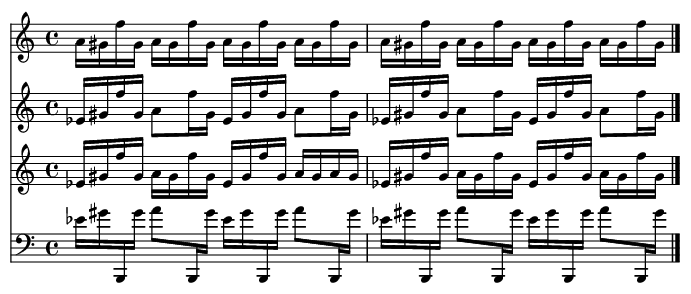

8/8 [==============================] - 69s 573ms/step - c_loss: -353.6552 - c_wass_loss: -935.4396 - c_gp: 58.1784 - g_loss: -563.5767
Epoch 2/1000
8/8 [==============================] - 4s 586ms/step - c_loss: -65.5023 - c_wass_loss: -101.5116 - c_gp: 3.6009 - g_loss: -398.2495
Epoch 3/1000
8/8 [==============================] - 3s 369ms/step - c_loss: -48.8603 - c_wass_loss: -74.6657 - c_gp: 2.5805 - g_loss: -1279.0167
Epoch 4/1000
8/8 [==============================] - 3s 346ms/step - c_loss: -56.8686 - c_wass_loss: -79.4486 - c_gp: 2.2580 - g_loss: -834.4207
Epoch 5/1000
8/8 [==============================] - 2s 308ms/step - c_loss: -67.5958 - c_wass_loss: -98.7713 - c_gp: 3.1175 - g_loss: -750.2731
Epoch 6/1000
8/8 [==============================] - 2s 310ms/step - c_loss: -60.1956 - c_wass_loss: -99.4147 - c_gp: 3.9219 - g_loss: -580.3502
Epoch 7/1000
8/8 [==============================] - 3s 375ms/step - c_loss: -57.6861 - c_wass_loss: -81.5792 - c_gp: 2.3893 - g_loss: -397.1054

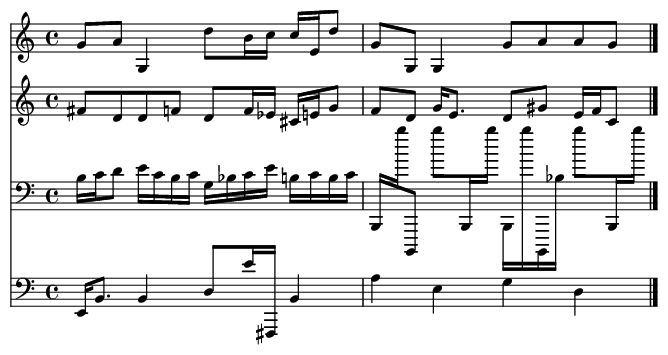

8/8 [==============================] - 4s 477ms/step - c_loss: -24.8893 - c_wass_loss: -42.4725 - c_gp: 1.7583 - g_loss: 100.7150
Epoch 102/1000
8/8 [==============================] - 3s 364ms/step - c_loss: -30.4997 - c_wass_loss: -43.6933 - c_gp: 1.3194 - g_loss: 103.2631
Epoch 103/1000
8/8 [==============================] - 3s 333ms/step - c_loss: -29.6361 - c_wass_loss: -43.7182 - c_gp: 1.4082 - g_loss: 80.6373
Epoch 104/1000
8/8 [==============================] - 2s 315ms/step - c_loss: -27.2073 - c_wass_loss: -47.1655 - c_gp: 1.9958 - g_loss: 100.4155
Epoch 105/1000
8/8 [==============================] - 2s 316ms/step - c_loss: -28.3941 - c_wass_loss: -38.2673 - c_gp: 0.9873 - g_loss: 39.3168
Epoch 106/1000
8/8 [==============================] - 2s 316ms/step - c_loss: -27.6526 - c_wass_loss: -42.0532 - c_gp: 1.4401 - g_loss: 107.1757
Epoch 107/1000
8/8 [==============================] - 3s 359ms/step - c_loss: -27.9669 - c_wass_loss: -44.9360 - c_gp: 1.6969 - g_loss: 125.4553
Ep

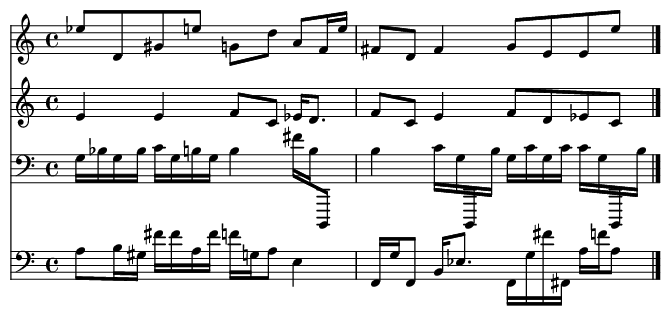

8/8 [==============================] - 4s 549ms/step - c_loss: -24.2960 - c_wass_loss: -30.9385 - c_gp: 0.6642 - g_loss: 23.6666
Epoch 202/1000
8/8 [==============================] - 3s 320ms/step - c_loss: -24.8264 - c_wass_loss: -31.7441 - c_gp: 0.6918 - g_loss: -38.3479
Epoch 203/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -23.5193 - c_wass_loss: -31.9116 - c_gp: 0.8392 - g_loss: 37.4742
Epoch 204/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -23.1939 - c_wass_loss: -34.4415 - c_gp: 1.1248 - g_loss: 31.7819
Epoch 205/1000
8/8 [==============================] - 3s 383ms/step - c_loss: -21.9300 - c_wass_loss: -33.0439 - c_gp: 1.1114 - g_loss: 10.4469
Epoch 206/1000
8/8 [==============================] - 3s 334ms/step - c_loss: -22.3555 - c_wass_loss: -31.7082 - c_gp: 0.9353 - g_loss: -41.6907
Epoch 207/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -21.8267 - c_wass_loss: -32.9424 - c_gp: 1.1116 - g_loss: -2.3334
Epoch

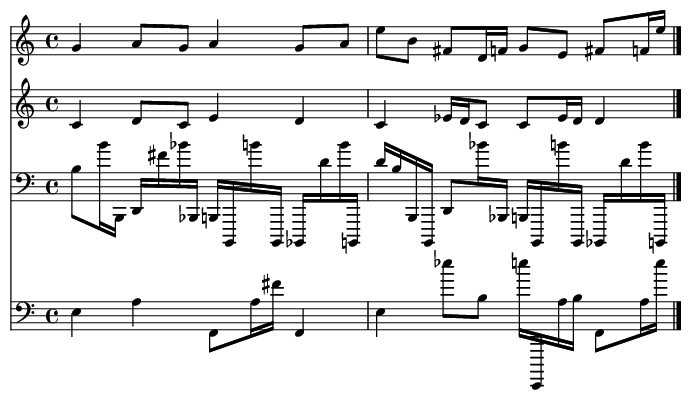

8/8 [==============================] - 4s 465ms/step - c_loss: -23.5322 - c_wass_loss: -31.7028 - c_gp: 0.8171 - g_loss: 11.9036
Epoch 302/1000
8/8 [==============================] - 3s 384ms/step - c_loss: -27.9286 - c_wass_loss: -36.0536 - c_gp: 0.8125 - g_loss: 90.6350
Epoch 303/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -28.8216 - c_wass_loss: -40.2811 - c_gp: 1.1460 - g_loss: -6.8220
Epoch 304/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -26.3285 - c_wass_loss: -43.4998 - c_gp: 1.7171 - g_loss: -33.6786
Epoch 305/1000
8/8 [==============================] - 3s 327ms/step - c_loss: -29.6837 - c_wass_loss: -36.5848 - c_gp: 0.6901 - g_loss: 35.9219
Epoch 306/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -27.4091 - c_wass_loss: -39.0127 - c_gp: 1.1604 - g_loss: 27.7084
Epoch 307/1000
8/8 [==============================] - 3s 379ms/step - c_loss: -26.1805 - c_wass_loss: -40.9827 - c_gp: 1.4802 - g_loss: -10.3684
Epoch

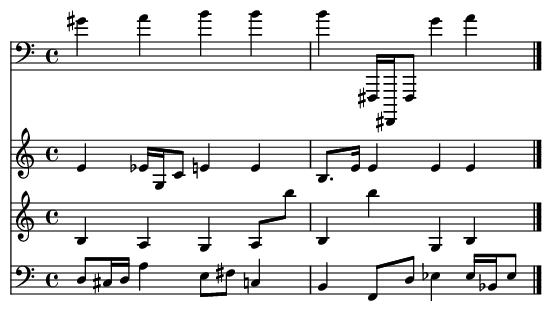

8/8 [==============================] - 3s 448ms/step - c_loss: -53.6355 - c_wass_loss: -83.7285 - c_gp: 3.0093 - g_loss: 11.3147
Epoch 402/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -48.0919 - c_wass_loss: -73.9548 - c_gp: 2.5863 - g_loss: 16.2955
Epoch 403/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -52.1586 - c_wass_loss: -71.2105 - c_gp: 1.9052 - g_loss: 10.8323
Epoch 404/1000
8/8 [==============================] - 3s 372ms/step - c_loss: -52.8621 - c_wass_loss: -82.9629 - c_gp: 3.0101 - g_loss: 7.6008
Epoch 405/1000
8/8 [==============================] - 3s 333ms/step - c_loss: -51.2514 - c_wass_loss: -77.3353 - c_gp: 2.6084 - g_loss: 16.7560
Epoch 406/1000
8/8 [==============================] - 2s 321ms/step - c_loss: -51.4570 - c_wass_loss: -79.7160 - c_gp: 2.8259 - g_loss: 16.5076
Epoch 407/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -53.0204 - c_wass_loss: -80.2327 - c_gp: 2.7212 - g_loss: 10.0206
Epoch 40

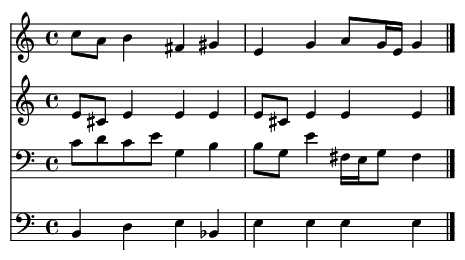

8/8 [==============================] - 4s 491ms/step - c_loss: -60.5760 - c_wass_loss: -97.6645 - c_gp: 3.7089 - g_loss: 21.9022
Epoch 502/1000
8/8 [==============================] - 3s 416ms/step - c_loss: -66.3778 - c_wass_loss: -96.7164 - c_gp: 3.0339 - g_loss: 33.8211
Epoch 503/1000
8/8 [==============================] - 2s 318ms/step - c_loss: -64.2048 - c_wass_loss: -95.9222 - c_gp: 3.1717 - g_loss: 20.4634
Epoch 504/1000
8/8 [==============================] - 2s 320ms/step - c_loss: -63.0810 - c_wass_loss: -116.9126 - c_gp: 5.3832 - g_loss: 31.4293
Epoch 505/1000
8/8 [==============================] - 2s 321ms/step - c_loss: -62.7357 - c_wass_loss: -93.9307 - c_gp: 3.1195 - g_loss: 57.2752
Epoch 506/1000
8/8 [==============================] - 3s 377ms/step - c_loss: -53.9754 - c_wass_loss: -99.2190 - c_gp: 4.5244 - g_loss: 20.1844
Epoch 507/1000
8/8 [==============================] - 3s 339ms/step - c_loss: -54.0369 - c_wass_loss: -101.5744 - c_gp: 4.7538 - g_loss: 27.6671
Epoch

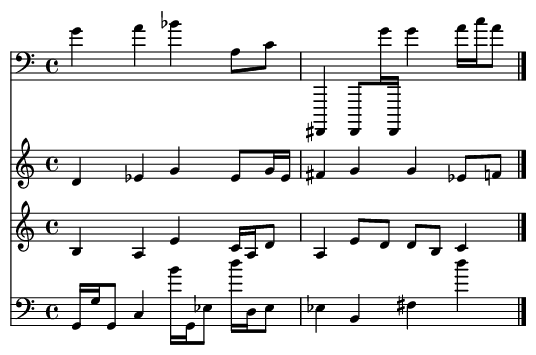

8/8 [==============================] - 3s 449ms/step - c_loss: -80.0296 - c_wass_loss: -116.5994 - c_gp: 3.6570 - g_loss: 34.9550
Epoch 602/1000
8/8 [==============================] - 2s 317ms/step - c_loss: -69.5157 - c_wass_loss: -110.1167 - c_gp: 4.0601 - g_loss: 31.0050
Epoch 603/1000
8/8 [==============================] - 2s 317ms/step - c_loss: -65.6963 - c_wass_loss: -110.2388 - c_gp: 4.4543 - g_loss: 33.4842
Epoch 604/1000
8/8 [==============================] - 3s 370ms/step - c_loss: -78.8985 - c_wass_loss: -139.4220 - c_gp: 6.0523 - g_loss: 34.2444
Epoch 605/1000
8/8 [==============================] - 3s 322ms/step - c_loss: -75.1530 - c_wass_loss: -109.5519 - c_gp: 3.4399 - g_loss: 39.8285
Epoch 606/1000
8/8 [==============================] - 2s 313ms/step - c_loss: -71.0659 - c_wass_loss: -109.5380 - c_gp: 3.8472 - g_loss: 34.6479
Epoch 607/1000
8/8 [==============================] - 3s 331ms/step - c_loss: -76.1043 - c_wass_loss: -113.0749 - c_gp: 3.6971 - g_loss: 27.6732


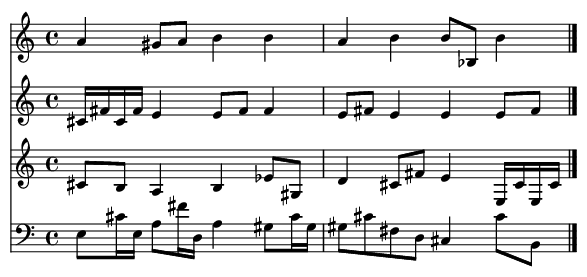

8/8 [==============================] - 4s 501ms/step - c_loss: -73.9590 - c_wass_loss: -120.6322 - c_gp: 4.6673 - g_loss: 37.5451
Epoch 702/1000
8/8 [==============================] - 3s 373ms/step - c_loss: -91.4605 - c_wass_loss: -137.0413 - c_gp: 4.5581 - g_loss: 40.0671
Epoch 703/1000
8/8 [==============================] - 3s 345ms/step - c_loss: -78.4947 - c_wass_loss: -120.4333 - c_gp: 4.1939 - g_loss: 31.8382
Epoch 704/1000
8/8 [==============================] - 2s 318ms/step - c_loss: -80.9745 - c_wass_loss: -131.8818 - c_gp: 5.0907 - g_loss: 42.3140
Epoch 705/1000
8/8 [==============================] - 3s 322ms/step - c_loss: -82.3529 - c_wass_loss: -126.7886 - c_gp: 4.4436 - g_loss: 22.4061
Epoch 706/1000
8/8 [==============================] - 2s 320ms/step - c_loss: 14.7463 - c_wass_loss: -155.1954 - c_gp: 16.9942 - g_loss: 44.4551
Epoch 707/1000
8/8 [==============================] - 3s 376ms/step - c_loss: -80.5434 - c_wass_loss: -121.4315 - c_gp: 4.0888 - g_loss: 22.6018


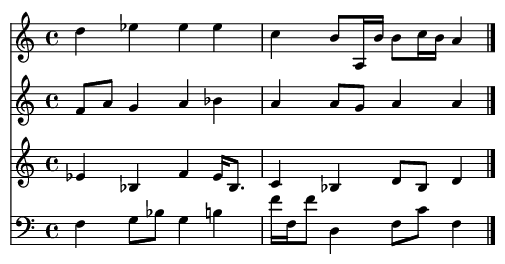

8/8 [==============================] - 4s 555ms/step - c_loss: -94.6652 - c_wass_loss: -146.0886 - c_gp: 5.1423 - g_loss: 40.0874
Epoch 802/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -77.6299 - c_wass_loss: -151.3741 - c_gp: 7.3744 - g_loss: 30.7525
Epoch 803/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -98.4869 - c_wass_loss: -143.4352 - c_gp: 4.4948 - g_loss: 37.7622
Epoch 804/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -82.0441 - c_wass_loss: -144.2014 - c_gp: 6.2157 - g_loss: 29.1212
Epoch 805/1000
8/8 [==============================] - 3s 331ms/step - c_loss: -83.1011 - c_wass_loss: -131.7200 - c_gp: 4.8619 - g_loss: 34.5756
Epoch 806/1000
8/8 [==============================] - 3s 437ms/step - c_loss: -86.7424 - c_wass_loss: -133.0108 - c_gp: 4.6268 - g_loss: 30.2833
Epoch 807/1000
8/8 [==============================] - 2s 317ms/step - c_loss: -91.3861 - c_wass_loss: -126.8683 - c_gp: 3.5482 - g_loss: 35.4698


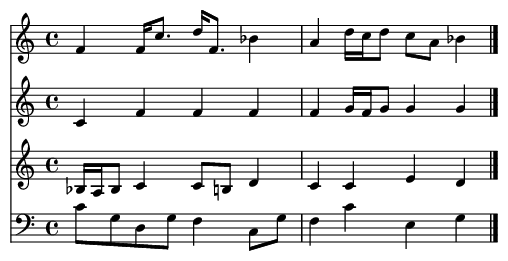

8/8 [==============================] - 3s 457ms/step - c_loss: -76.6841 - c_wass_loss: -138.0615 - c_gp: 6.1377 - g_loss: 21.8867
Epoch 902/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -83.3920 - c_wass_loss: -136.9344 - c_gp: 5.3542 - g_loss: 36.0971
Epoch 903/1000
8/8 [==============================] - 3s 370ms/step - c_loss: -41.1042 - c_wass_loss: -173.0296 - c_gp: 13.1925 - g_loss: 66.2479
Epoch 904/1000
8/8 [==============================] - 3s 344ms/step - c_loss: -91.8318 - c_wass_loss: -131.8097 - c_gp: 3.9978 - g_loss: 22.6029
Epoch 905/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -76.5766 - c_wass_loss: -130.2537 - c_gp: 5.3677 - g_loss: 30.6295
Epoch 906/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -85.0989 - c_wass_loss: -132.4958 - c_gp: 4.7397 - g_loss: 49.8753
Epoch 907/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -91.7425 - c_wass_loss: -136.3747 - c_gp: 4.4632 - g_loss: 20.6980

In [45]:
history = musegan.fit(
    data_binary,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator_callback,
    ],
)

새로운 악보 생성

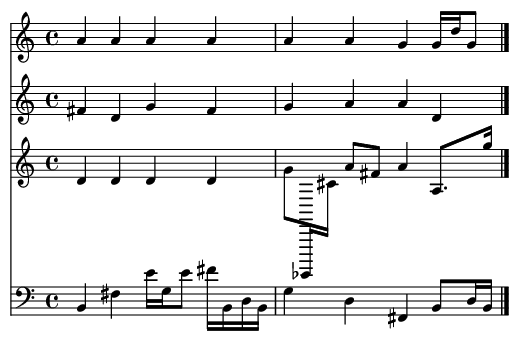

In [46]:
num_scores = 1
chords_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
style_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
melody_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
groove_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
random_latent_vectors = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music = generator(random_latent_vectors)
generated_music = generated_music.numpy()

notes_to_midi(
    generated_music, N_BARS, N_TRACKS, N_STEPS_PER_BAR, filename="output_midi"
)
display(Image(str(draw_score("output_midi", 0).write('lily.png'))))

화음의 잡음 변경

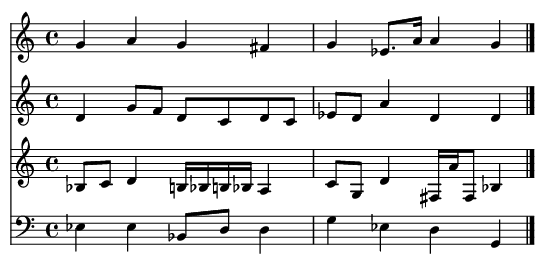

In [47]:
chords_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_2 = [
    chords_random_latent_vectors_2,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_2 = generator(random_latent_vectors_2)
generated_music_2 = generated_music_2.numpy()
notes_to_midi(
    generated_music_2,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_chords_changed",
)
display(Image(str(draw_score("output_midi_chords_changed", 0).write('lily.png'))))

스타일 잡음 변경

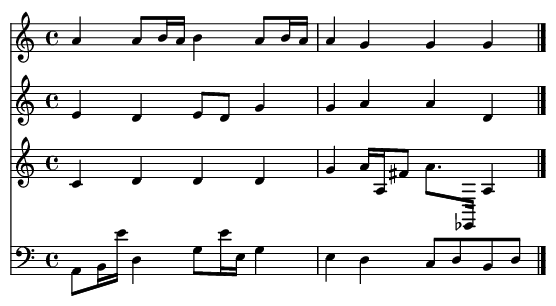

In [48]:
style_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_3 = [
    chords_random_latent_vectors,
    style_random_latent_vectors_2,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_3 = generator(random_latent_vectors_3)
generated_music_3 = generated_music_3.numpy()
notes_to_midi(
    generated_music_3,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_style_changed",
)
display(Image(str(draw_score("output_midi_style_changed", 0).write('lily.png'))))